<ipython-input-20-fae72bcd5ce9>:54: RuntimeWarning: invalid value encountered in true_divide
  accept_pro = (likelihood_proposal*prior_proposal)/(likelihood_current_location*prior_current_location)
<ipython-input-20-fae72bcd5ce9>:54: RuntimeWarning: divide by zero encountered in true_divide
  accept_pro = (likelihood_proposal*prior_proposal)/(likelihood_current_location*prior_current_location)


[341.48681016886684, 341.57495726705463, 341.55103349587, 342.23398766731106, 347.7866175999481, 382.06531820097456, 424.62008250290035, 433.29405997324227, 434.0980938056939]
[380.04394180773903, 380.0747280160853, 380.1416464314838, 380.7314245860523, 386.3158579014044, 420.81547593447203, 463.20094864195926, 471.8827864245807, 472.77416959466603]
[418.90969112273206, 418.8795977529072, 418.7449526858819, 419.5262756914971, 425.0791365080855, 459.67206083753314, 501.75152474995025, 510.81415448300834, 511.45190137081323]


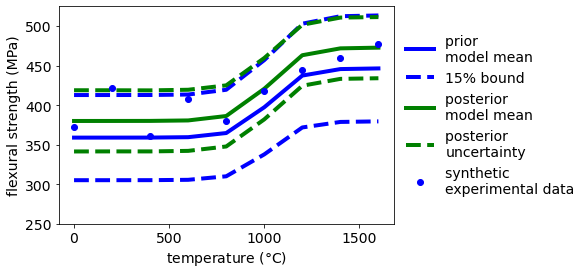

In [20]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 14})
from mpl_toolkits.mplot3d import Axes3D 
import scipy
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.integrate import odeint
import pandas as pd
import seaborn as sns
import pickle

#centered_synth_exp = [341.34307562, 343.39421741, 332.72204114, 370.54835985, 
#                      347.52350974, 400.16028132, 432.76704837, 417.17647725, 425.15201902]
#shifted_up_exp = [371.93923856, 422.0748083, 360.47125363, 407.79689099, 380.09236394,
#            417.76626157, 444.91269431, 459.29178947, 478.02731897]
#shifted_down_exp = [303.78800408, 317.47338596, 351.81246919, 333.06652442, 343.87121988, 
#                    393.48889663, 401.80579517, 424.7875635, 433.83970035]
#shifted_left_synth_exp = [349.95490152, 355.89666548, 410.05829427, 393.77353699, 421.84752866,
#                          441.0380559, 448.98198769, 435.41553941, 451.91814983]

class ip:
    # Q (for proposal samples).  
    # Initialize experimental data.
    mcmc_length = 250000
    mcmc_burn_in = 10000 # number of samples
    mu_prior = np.array([1.0])
    cov_prior = np.array([1.0])

    synth_exp = shifted_up_exp = [371.93923856, 422.0748083, 360.47125363, 407.79689099, 380.09236394,
            417.76626157, 444.91269431, 459.29178947, 478.02731897]
    
    Q_mu = np.array([0])
    Q_cov = cov_prior
    #main function to get samples
    def MetropolisHastings(self):
        samples = np.zeros((self.mcmc_length,1)) 
        samples[0,:] = self.mu_prior #initialize the chain
        likelihoods_vec = np.zeros((self.mcmc_length,1))
        posteriors_un_normed_vec = np.zeros((self.mcmc_length,1))
        priors_vec = np.zeros((self.mcmc_length,1))
        for i in range(1,self.mcmc_length):
            proposal_sample = samples[i-1,:] + np.sqrt(self.Q_cov)*np.random.randn() + self.Q_mu, #
            prior_proposal = self.prior(proposal_sample)
            likelihood_proposal = self.likelihood(proposal_sample)
            prior_current_location = self.prior(samples[i-1,:])
            likelihood_current_location = self.likelihood(samples[i-1,:])
            accept_pro = (likelihood_proposal*prior_proposal)/(likelihood_current_location*prior_current_location)
            uni_rand = np.random.uniform()
            if uni_rand<accept_pro:
                samples[i,:] = proposal_sample
                posteriors_un_normed_vec[i] = likelihood_proposal*prior_proposal
                likelihoods_vec[i] = likelihood_proposal
                priors_vec[i] = prior_proposal
            else:
                samples[i,:] = samples[i-1,:]
                posteriors_un_normed_vec[i] = likelihood_current_location*prior_current_location
                likelihoods_vec[i] = likelihood_current_location
                priors_vec[i] = prior_current_location
            ########################################
        samples = samples[self.mcmc_burn_in:]
        posteriors_un_normed_vec = posteriors_un_normed_vec[self.mcmc_burn_in:]
        likelihoods_vec = likelihoods_vec[self.mcmc_burn_in:]
        priors_vec = priors_vec[self.mcmc_burn_in:]
        #posterior probabilites are transformed to a standard normal (std=1)
        #for obtaining the evidence:
        evidence = np.mean(posteriors_un_normed_vec)*np.sqrt(2*np.pi*np.std(samples)**2)
        posteriors_vec = posteriors_un_normed_vec/evidence
        log_ratios = np.log(posteriors_vec/priors_vec)
        log_ratios[np.isinf(log_ratios)] = 0
        log_ratios = np.nan_to_num(log_ratios)
        info_gain = np.mean(log_ratios)
        return [evidence, info_gain, samples]
    
    def prior(self,sample):
        probability = np.exp(-(sample[0]))# Weibull prior
        #probability = multivariate_normal.pdf(x=sample, mean=self.mu_prior, cov=self.cov_prior, allow_singular=False)
        return probability
        
    def likelihood(self,sample): # The model goes in here
        T = np.linspace(0,1600,9)
        beta = 87.6
        FS_array = (359+beta/(1+np.exp(-0.012*(T-1020.67))))*sample
        SSE = np.sum(np.square(FS_array - self.synth_exp))/9
        #print(SSE)
        probability_ra = multivariate_normal.pdf(x=SSE,mean=0, cov=400)  
        #print(probability_ra)
        return probability_ra
#-------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------
 

evidences=[]
info_gains=[]
all_samples=[]

ip_object = ip()

[evidence, info_gain, samples] = ip_object.MetropolisHastings()
#evidences.append(evidence)
#info_gains.append(info_gain)
#all_samples.append(samples)
#print('Evidence: ' + str(evidence))
#print('Information Gain: ' + str(info_gain))
#print('Samples: ' +str(samples))
#print(samples.shape)  
#evidencearray = np.asarray(evidences)
#print('evidence shape')
#print(evidencearray.shape)

T = np.linspace(0,1600,9)

FS_upper_bound = []
FS_lower_bound = []
FS_mean = []
for temp in T:
    FS_temp = (359+87.6/(1+np.exp(-0.012*(temp-1020.67))))*samples
    #for i in FS_temp:
    #    FS_temp[i] = FS_temp[i] + 10*np.random.randn()
    #print(10*np.random.randn(len(FS_temp),1))
    FS_temp_total = FS_temp + 15*np.random.randn(len(FS_temp),1)
    #print(FS_temp)
    #print(FS_temp_total)
    FS_temp_total_sorted = np.sort(FS_temp_total, axis=0)
    #print(FS_temp_total.shape)
    #print(FS_temp_total_sorted)
    #print(int(np.round(0.05*len(FS_temp))))
    #print(int(np.round(0.95*len(FS_temp))))
    #print(int(np.round(0.5*len(FS_temp))))
    FS_lower_bound.append(FS_temp_total_sorted[int(np.round(0.005*len(FS_temp))),0])
    FS_upper_bound.append(FS_temp_total_sorted[int(np.round(0.995*len(FS_temp))),0])
    FS_mean.append(FS_temp_total_sorted[int(np.round(0.5*len(FS_temp))),0])
#print(samples)
print(FS_lower_bound)
print(FS_mean)
print(FS_upper_bound)

synth_exp = np.array([371.93923856, 422.0748083, 360.47125363, 407.79689099, 380.09236394,
            417.76626157, 444.91269431, 459.29178947, 478.02731897]) 

FS = 359+87.6/(1+np.exp(-0.012*(T-1020.67)))
FS_upper_15_percent = 1.15*359+1.15*87.6/(1+np.exp(-0.012*(T-1020.67)))
FS_lower_15_percent = 0.85*359+0.85*87.6/(1+np.exp(-0.012*(T-1020.67)))

plt.plot(T,FS,'b', linewidth = 4, label = 'prior \nmodel mean')
plt.plot(T,FS_upper_15_percent,'b--', linewidth = 4, label = '15% bound')
plt.plot(T,FS_lower_15_percent,'b--',linewidth = 4)
plt.plot(T,FS_mean,'g',linewidth = 4,label = 'posterior \nmodel mean')
plt.plot(T,FS_upper_bound,'g--',linewidth = 4, label = 'posterior \nuncertainty')
plt.plot(T,FS_lower_bound,'g--',linewidth = 4)
plt.plot(T,synth_exp,'bo',label = 'synthetic \nexperimental data') #standard deviation 20 MPa
plt.ylim([250,525])
# Put a legend to the right of the current axis
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False)
#plt.legend(loc='upper left')
plt.ylabel(r'flexural strength (MPa)')
plt.xlabel(r'temperature ($\degree$C)')
plt.savefig('Bayes_flexural_strength_centered.png',dpi=300,bbox_inches='tight')


bound =  [0.10226646 0.102098   0.10154979 0.10189558 0.10034089 0.0923364
 0.08322646 0.0825022  0.08181016]
R squared posterior=  0.7289574167599359
R squared prior=  0.3561265510310848


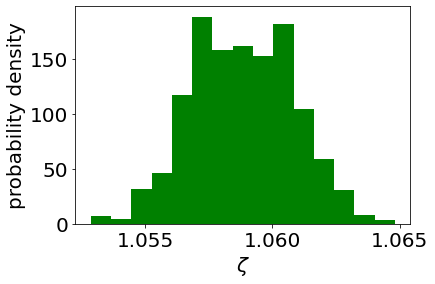

In [21]:
matplotlib.rcParams.update({'font.size': 20})
FS_upper_bound = np.array(FS_upper_bound)
FS_mean = np.array(FS_mean)
print("bound = ", (FS_upper_bound - FS_mean) / FS_mean)
SSE = np.sum(np.power(FS_mean - synth_exp,2))
TSS = np.sum(np.power(synth_exp - np.mean(synth_exp),2))
print("R squared posterior= ", 1 - SSE/TSS)
SSE_pri = np.sum(np.power(FS - synth_exp,2))
print("R squared prior= ", 1 - SSE_pri/TSS)
zeta_prior = 1 + np.random.randn(40000)
samples = samples.flatten()
plt.hist(samples,label=r'$\zeta$ posterior',color='g',bins=15,density=True)
plt.xlabel(r'$\zeta$')
plt.ylabel(r'probability density')
#plt.legend(frameon=False)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.savefig('scenario_two_zeta_param_2024.png',dpi=300,bbox_inches='tight')


<ipython-input-22-b4fa0d705572>:8: RuntimeWarning: invalid value encountered in true_divide
  KL_samples = n_p*np.log2(n_p/n_q)
<ipython-input-22-b4fa0d705572>:8: RuntimeWarning: divide by zero encountered in log2
  KL_samples = n_p*np.log2(n_p/n_q)
<ipython-input-22-b4fa0d705572>:8: RuntimeWarning: invalid value encountered in multiply
  KL_samples = n_p*np.log2(n_p/n_q)


1.2934274251655193


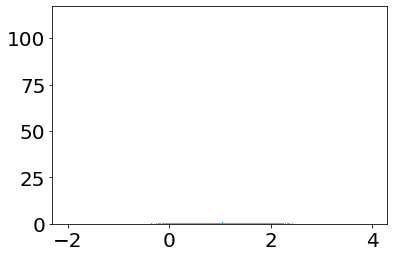

In [22]:
# KL divergence
#zeta_prior, samples

bins = np.linspace(-2,4,1001)
n_p, bins, patches = plt.hist(samples, bins=bins, density=True)
n_q, bins, patches = plt.hist(zeta_prior, bins=bins, density=True)

KL_samples = n_p*np.log2(n_p/n_q)
KL_samples[np.isnan(KL_samples)] = 0
KL = np.mean(KL_samples)
print(KL)
    
p_mean = np.mean(samples)
p_std = np.std(samples)

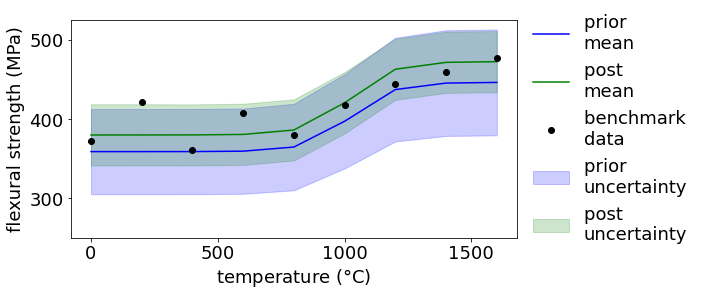

In [23]:
matplotlib.rcParams.update({'font.size': 18})
plt.figure(figsize=(8,4))
plt.plot(T,FS,'b',label = 'prior \nmean')
plt.fill_between(T,FS_upper_15_percent,FS_lower_15_percent,color='b', alpha=0.2, label = 'prior \nuncertainty')
plt.plot(T,FS_mean,'g',label = 'post \nmean')
plt.fill_between(T,FS_upper_bound,FS_lower_bound,color='g', alpha=0.2, label = 'post \nuncertainty')
plt.plot(T,synth_exp,'ko',label = 'benchmark \ndata') #standard deviation 20 MPa
plt.ylim([250,525])
# Put a legend to the right of the current axis
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False)
#plt.legend(loc='upper left')
plt.ylabel(r'flexural strength (MPa)')
plt.xlabel(r'temperature ($\degree$C)')
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=6)
plt.savefig('scenario_two_raised_2024.png',dpi=300,bbox_inches='tight')